# Anomalous SST Trend 

## $$Historical - \overline{PIC}  = Anomaly$$

### `pip install dask --force-reinstall` in terminal to fix error when opening ds
`Python Xarray ValueError: unrecognized chunk manager dask - must be one of: []`

In [1]:
import xarray as xr 
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
historical = xr.open_mfdataset('/work/Shanice.Bailey/ESM4/historical_1850-2014/ocean_*.nc', decode_times=False)

In [3]:
pic = xr.open_mfdataset('/work/Shanice.Bailey/ESM4/PIC/ocean_*.tos.nc', decode_times=False)

In [4]:
historical

<xarray.Dataset> Size: 100GB
Dimensions:     (time: 60225, nv: 2, yh: 576, xh: 720)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) float64 482kB 0.5 1.5 2.5 ... 6.022e+04 6.022e+04
  * xh          (xh) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * yh          (yh) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Data variables:
    average_DT  (time) float64 482kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T1  (time) float64 482kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T2  (time) float64 482kB dask.array<chunksize=(1825,), meta=np.ndarray>
    time_bnds   (time, nv) float64 964kB dask.array<chunksize=(1825, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 100GB dask.array<chunksize=(1825, 576, 720), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.18500101-18541231.tos.nc
    title:               ESM4_esm-hist_D1
    associated_files:    areacello: 18500101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

In [5]:
pic

<xarray.Dataset> Size: 200GB
Dimensions:     (time: 120450, nv: 2, yh: 576, xh: 720)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) float64 964kB 0.5 1.5 2.5 ... 1.825e+05 1.825e+05
  * xh          (xh) float64 6kB -299.8 -299.2 -298.8 ... 58.75 59.25 59.75
  * yh          (yh) float64 5kB -77.91 -77.72 -77.54 ... 89.47 89.68 89.89
Data variables:
    average_DT  (time) float64 964kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T1  (time) float64 964kB dask.array<chunksize=(1825,), meta=np.ndarray>
    average_T2  (time) float64 964kB dask.array<chunksize=(1825,), meta=np.ndarray>
    time_bnds   (time, nv) float64 2MB dask.array<chunksize=(1825, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 200GB dask.array<chunksize=(1825, 576, 720), meta=np.ndarray>
Attributes:
    filename:            ocean_daily_cmip.00010101-00051231.tos.nc
    title:               ESM4_esm-piControl_D
    associated_files:    areacello: 00010101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello

Got this warning during PIC download 

In [6]:
#see what local dask is doing in the background 
from dask.distributed import LocalCluster, Client
import dask

with dask.config.set(**{"distributed.dashboard.link": "http://localhost:8888/lab/tree/work/Shanice.Bailey/MHW-gfdl/sst-trend-ESM4.ipynb"}):
    cluster = LocalCluster()
    client = Client(cluster)

In [7]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 502.62 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43317,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 502.62 GiB
Comm: tcp://127.0.0.1:46739,Total threads: 4
Dashboard: http://127.0.0.1:34983/status,Memory: 125.66 GiB
Nanny: tcp://127.0.0.1:39391,


In [52]:
gom = dict(xh=slice(-100,-80), yh=slice(17,31))
pic_gom1 = pic.tos.sel(**gom)

hist_gom = historical.tos.sel(**gom).assign_coords({'time':np.tile(np.arange(1,366), 165)})
pic_gom = pic_gom1.assign_coords({'time':np.tile(np.arange(1,366), 330)})

In [53]:
hist_gom

<xarray.DataArray 'tos' (time: 60225, yh: 32, xh: 40)> Size: 308MB
dask.array<getitem, shape=(60225, 32, 40), dtype=float32, chunksize=(1825, 32, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * time     (time) int64 482kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [54]:
pic_gom

<xarray.DataArray 'tos' (time: 120450, yh: 32, xh: 40)> Size: 617MB
dask.array<getitem, shape=(120450, 32, 40), dtype=float32, chunksize=(1825, 32, 40), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * time     (time) int64 964kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

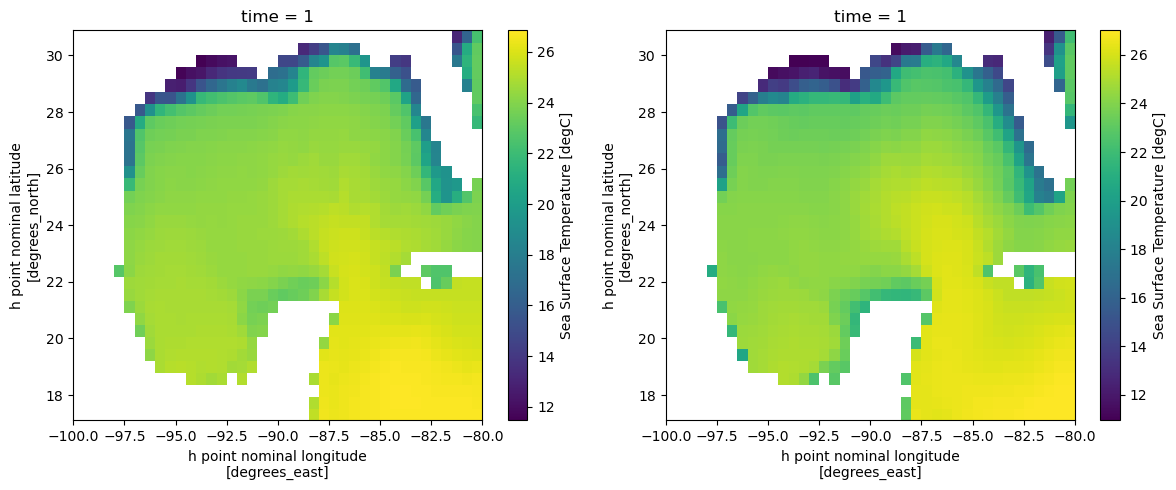

In [55]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
pic_gom[0].plot(ax=ax0)
hist_gom[0].plot(ax=ax1)
plt.tight_layout();

In [57]:
hist_gom.load()

<xarray.DataArray 'tos' (time: 60225, yh: 32, xh: 40)> Size: 308MB
array([[[       nan,        nan,        nan, ..., 26.997465 ,
         27.005512 , 27.007095 ],
        [       nan,        nan,        nan, ..., 26.99496  ,
         27.01473  , 27.005428 ],
        [       nan,        nan,        nan, ..., 26.944859 ,
         26.986662 , 26.977589 ],
        ...,
        [       nan,        nan,        nan, ..., 14.660028 ,
         20.074034 , 23.06574  ],
        [       nan,        nan,        nan, ..., 13.383856 ,
         19.12203  , 22.831985 ],
        [       nan,        nan,        nan, ..., 12.262839 ,
         15.496625 , 22.06744  ]],

       [[       nan,        nan,        nan, ..., 26.986681 ,
         26.991365 , 26.95905  ],
        [       nan,        nan,        nan, ..., 26.973396 ,
         26.980297 , 26.965391 ],
        [       nan,        nan,        nan, ..., 26.974096 ,
         26.978815 , 26.968145 ],
...
        [       nan,        nan,        nan, ..., 19.847744 ,
         23.074043 , 25.209208 ],
        [       nan,        nan,        nan, ..., 18.509842 ,
         22.163412 , 25.129604 ],
        [       nan,        nan,        nan, ..., 17.121704 ,
         19.453796 , 24.671757 ]],

       [[       nan,        nan,        nan, ..., 27.847578 ,
         27.806822 , 27.733543 ],
        [       nan,        nan,        nan, ..., 27.787123 ,
         27.76271  , 27.703348 ],
        [       nan,        nan,        nan, ..., 27.77857  ,
         27.741814 , 27.709885 ],
        ...,
        [       nan,        nan,        nan, ..., 19.8807   ,
         23.071245 , 25.14337  ],
        [       nan,        nan,        nan, ..., 18.504723 ,
         21.932922 , 25.006456 ],
        [       nan,        nan,        nan, ..., 17.097975 ,
         19.10137  , 24.417767 ]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * time     (time) int64 482kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [56]:
pic_gom.load()

<xarray.DataArray 'tos' (time: 120450, yh: 32, xh: 40)> Size: 617MB
array([[[      nan,       nan,       nan, ..., 26.753643, 26.749989,
         26.732607],
        [      nan,       nan,       nan, ..., 26.744268, 26.73512 ,
         26.709816],
        [      nan,       nan,       nan, ..., 26.678795, 26.676712,
         26.656055],
        ...,
        [      nan,       nan,       nan, ..., 17.643017, 21.417078,
         23.148626],
        [      nan,       nan,       nan, ..., 15.495462, 20.878527,
         23.071293],
        [      nan,       nan,       nan, ..., 13.134256, 16.394928,
         22.293331]],

       [[      nan,       nan,       nan, ..., 26.72423 , 26.711575,
         26.68386 ],
        [      nan,       nan,       nan, ..., 26.715471, 26.703812,
         26.679564],
        [      nan,       nan,       nan, ..., 26.645298, 26.640959,
         26.616507],
...
        [      nan,       nan,       nan, ..., 17.12901 , 20.414942,
         22.73917 ],
        [      nan,       nan,       nan, ..., 16.149519, 20.061945,
         22.58378 ],
        [      nan,       nan,       nan, ..., 14.377865, 17.887934,
         21.594276]],

       [[      nan,       nan,       nan, ..., 26.37832 , 26.341688,
         26.295858],
        [      nan,       nan,       nan, ..., 26.365831, 26.326439,
         26.289232],
        [      nan,       nan,       nan, ..., 26.374912, 26.331133,
         26.303452],
        ...,
        [      nan,       nan,       nan, ..., 16.723389, 20.34042 ,
         22.691391],
        [      nan,       nan,       nan, ..., 15.730906, 19.866835,
         22.464262],
        [      nan,       nan,       nan, ..., 14.067711, 17.722136,
         21.784267]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * time     (time) int64 964kB 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [58]:
#Compute daily climatology of sst's
pic_clim = pic_gom.groupby('time').mean('time')
hist_clim = hist_gom.groupby('time').mean('time')

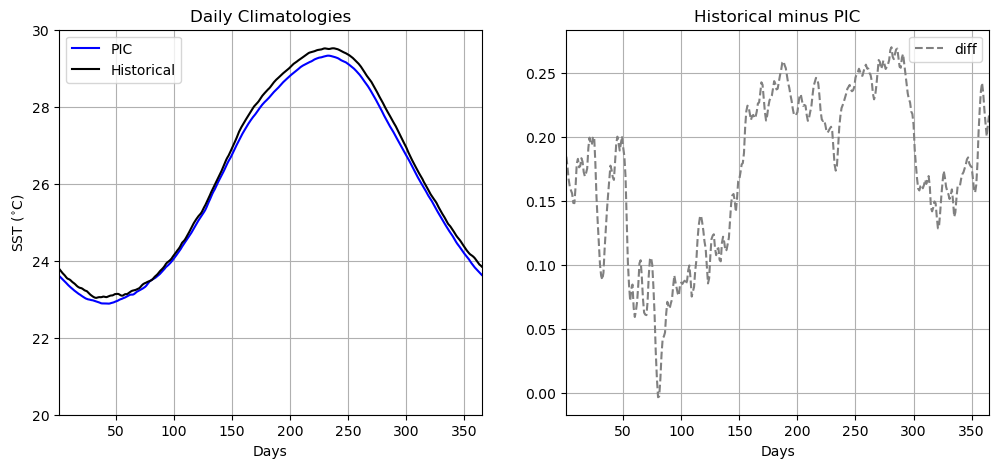

In [59]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
pic_clim.mean(('yh','xh')).plot(color='blue', label='PIC', ax=ax0)
hist_clim.mean(('yh','xh')).plot(color='k', label='Historical', ax=ax0)
(hist_clim-pic_clim).mean(('yh','xh')).plot(ax=ax1, color='grey', linestyle='dashed', label='diff')
ax0.grid()
ax1.grid()
ax0.set_xlim(1,365)
ax1.set_xlim(1,365)
ax0.set_ylim(20, 30)
ax0.set_ylabel(r'SST ($^{\circ}$C)')
ax0.set_xlabel('Days')
ax0.set_title('Daily Climatologies')
ax1.set_ylabel('')
ax1.set_xlabel('Days')
ax1.set_title('Historical minus PIC')
ax0.legend()
ax1.legend();

In [60]:
# Calculate anomalous SST (variable forcing = (internal variability + variable forcing) - internal variability)
anom = hist_gom.groupby('time') - pic_clim

In [97]:
#create datetime object for time dim
#get rid of the leap days that pd.date_range automatically includes
no_leap = pd.date_range(start='1850-01-01', periods=60265, freq='D')
no_leap = no_leap[~((no_leap.month == 2) & (no_leap.day == 29))]

anom_gom = anom.assign_coords({'time':no_leap})

In [62]:
anom_gom

<xarray.DataArray 'tos' (time: 60225, yh: 32, xh: 40)> Size: 308MB
array([[[        nan,         nan,         nan, ...,  0.4817772 ,
          0.5053768 ,  0.5156441 ],
        [        nan,         nan,         nan, ...,  0.47146797,
          0.5023136 ,  0.49864197],
        [        nan,         nan,         nan, ...,  0.42627144,
          0.47348404,  0.46925545],
        ...,
        [        nan,         nan,         nan, ..., -0.9214392 ,
         -0.29018402,  0.19492912],
        [        nan,         nan,         nan, ..., -0.83734417,
         -0.35700226,  0.11366272],
        [        nan,         nan,         nan, ..., -0.45398235,
         -0.34355164,  0.21015358]],

       [[        nan,         nan,         nan, ...,  0.500288  ,
          0.5202179 ,  0.49481773],
        [        nan,         nan,         nan, ...,  0.47800064,
          0.49679756,  0.48792267],
        [        nan,         nan,         nan, ...,  0.48396492,
          0.4942131 ,  0.48956108],
...
        [        nan,         nan,         nan, ...,  4.2453766 ,
          2.6432915 ,  2.2758274 ],
        [        nan,         nan,         nan, ...,  4.262044  ,
          2.638607  ,  2.3487988 ],
        [        nan,         nan,         nan, ...,  4.318825  ,
          3.582714  ,  2.731367  ]],

       [[        nan,         nan,         nan, ...,  1.2993202 ,
          1.2739296 ,  1.2085285 ],
        [        nan,         nan,         nan, ...,  1.2329445 ,
          1.2188683 ,  1.1639652 ],
        [        nan,         nan,         nan, ...,  1.2301712 ,
          1.1978798 ,  1.1689434 ],
        ...,
        [        nan,         nan,         nan, ...,  4.3474636 ,
          2.686905  ,  2.2482738 ],
        [        nan,         nan,         nan, ...,  4.3307304 ,
          2.4528522 ,  2.26577   ],
        [        nan,         nan,         nan, ...,  4.3866463 ,
          3.294176  ,  2.5357456 ]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * time     (time) datetime64[ns] 482kB 1850-01-01 1850-01-02 ... 2014-12-31

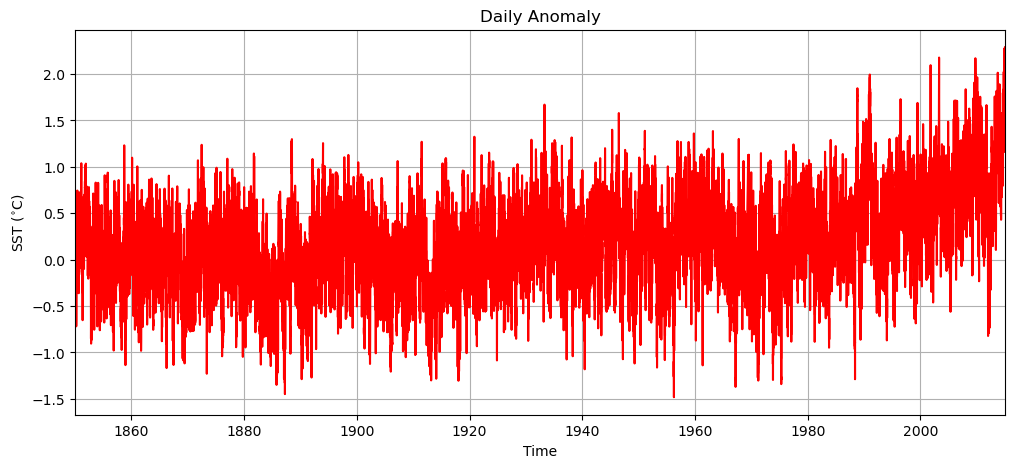

In [63]:
plt.figure(figsize=(12,5))
anom_gom.mean(('yh','xh')).plot(color='r')
plt.grid()
plt.ylabel(r'SST ($^{\circ}$C)')
plt.xlabel('Time')
plt.xlim(anom_gom.time[0], anom_gom.time[-1])
plt.title('Daily Anomaly');

In [94]:
pic_std = pic_gom.std(dim='time')
hist_std = hist_gom.std(dim='time')

/app/conda/miniforge/envs/python-311-jupyter/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/app/conda/miniforge/envs/python-311-jupyter/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


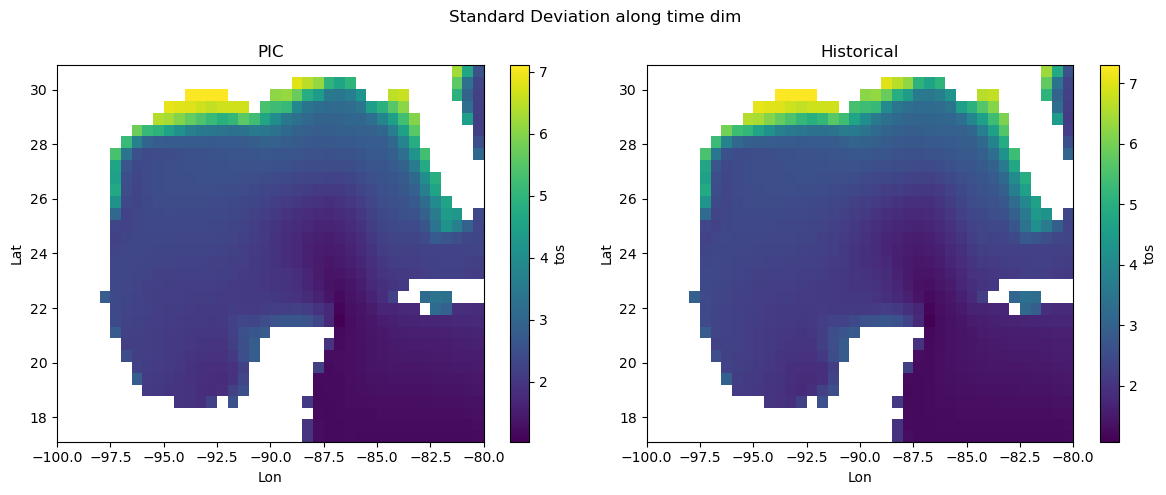

In [151]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))
pic_std.plot(ax=ax0)
ax0.set_title('PIC')
ax0.set_ylabel('Lat')
ax0.set_xlabel('Lon')
hist_std.plot(ax=ax1)
ax1.set_title('Historical')
ax1.set_ylabel('Lat')
ax1.set_xlabel('Lon')
plt.suptitle('Standard Deviation along time dim')
plt.tight_layout();

### Plot trend line and trend map

In [73]:
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend = linregress(np.arange(0,60225), anom_gom.mean(['xh', 'yh']))

In [74]:
trend

LinregressResult(slope=1.1550387734286546e-05, intercept=-0.1732681532052332, rvalue=0.40563424718572705, pvalue=0.0, stderr=1.0605809183605166e-07, intercept_stderr=0.0036876914980153103)

In [75]:
trend_line = (trend[0]*np.arange(0,60225) + trend[1])

In [76]:
trend_line

array([-0.17326815, -0.1732566 , -0.17324505, ...,  0.5223193 ,
        0.52233085,  0.5223424 ])

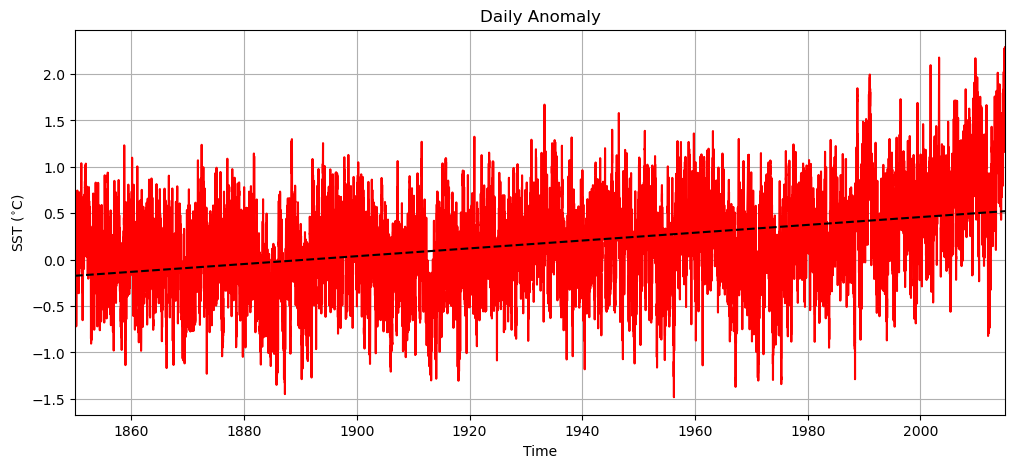

In [77]:
plt.figure(figsize=(12,5))
anom_gom.mean(('yh','xh')).plot(color='r')
plt.plot(anom_gom.time, trend_line, color='k', linestyle='dashed')
plt.grid()
plt.ylabel(r'SST ($^{\circ}$C)')
plt.xlabel('Time')
plt.xlim(anom_gom.time[0], anom_gom.time[-1])
plt.title('Daily Anomaly');

In [78]:
#linear regression at every grid cell over time, so that we see trend rate in ˚C/yr at each grid pt
# Calculate the linear trend at each grid point
trend = anom_gom.groupby('time.year').mean('time').polyfit('year', deg=1)

In [79]:
trend

<xarray.Dataset> Size: 21kB
Dimensions:               (yh: 32, xh: 40, degree: 2)
Coordinates:
  * yh                    (yh) float64 256B 17.31 17.73 18.14 ... 30.24 30.67
  * xh                    (xh) float64 320B -99.75 -99.25 ... -80.75 -80.25
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, yh, xh) float64 20kB nan nan ... -6.904

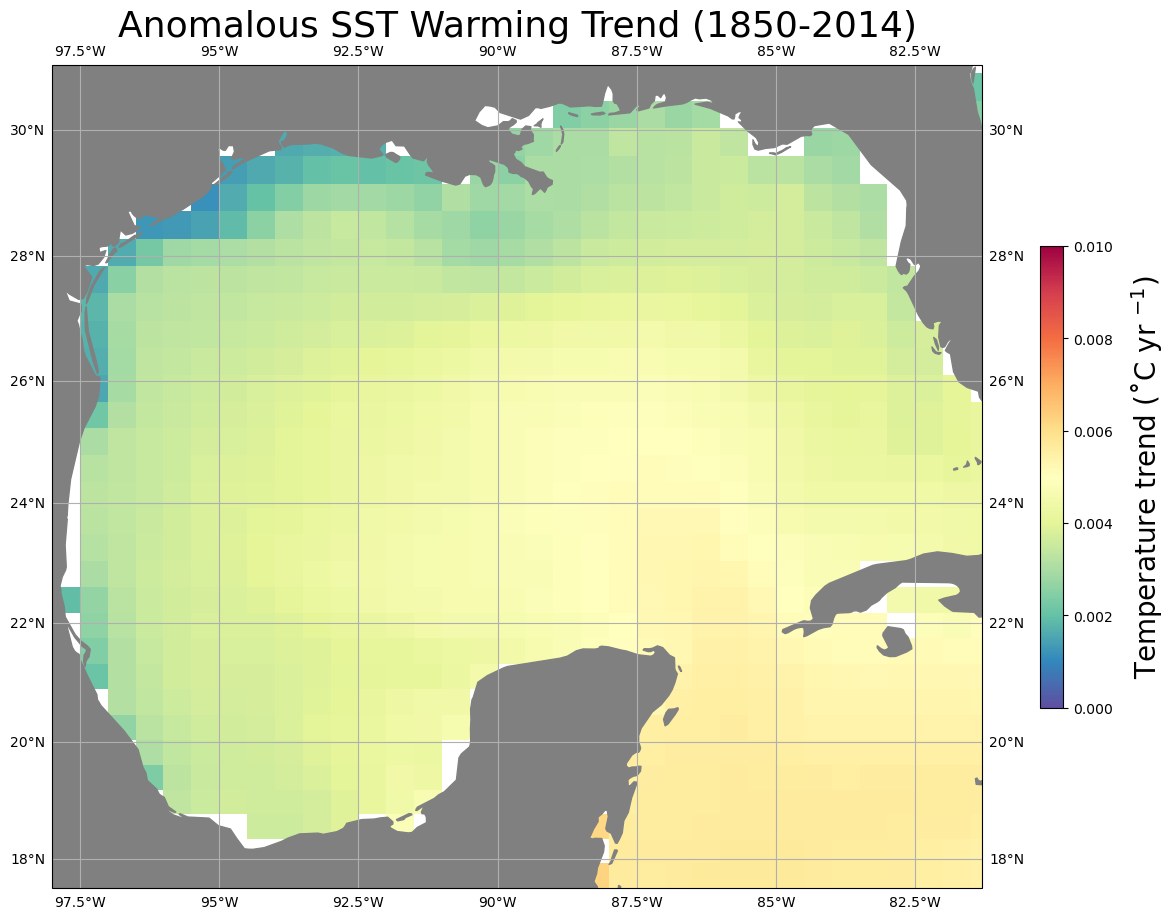

In [102]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=0, vmax=0.01)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Anomalous SST Warming Trend (1850-2014)', fontsize=26);

In [104]:
hist_gom_rt = hist_gom.assign_coords({'time':no_leap})

In [105]:
hist_gom_rt

<xarray.DataArray 'tos' (time: 60225, yh: 32, xh: 40)> Size: 308MB
array([[[       nan,        nan,        nan, ..., 26.997465 ,
         27.005512 , 27.007095 ],
        [       nan,        nan,        nan, ..., 26.99496  ,
         27.01473  , 27.005428 ],
        [       nan,        nan,        nan, ..., 26.944859 ,
         26.986662 , 26.977589 ],
        ...,
        [       nan,        nan,        nan, ..., 14.660028 ,
         20.074034 , 23.06574  ],
        [       nan,        nan,        nan, ..., 13.383856 ,
         19.12203  , 22.831985 ],
        [       nan,        nan,        nan, ..., 12.262839 ,
         15.496625 , 22.06744  ]],

       [[       nan,        nan,        nan, ..., 26.986681 ,
         26.991365 , 26.95905  ],
        [       nan,        nan,        nan, ..., 26.973396 ,
         26.980297 , 26.965391 ],
        [       nan,        nan,        nan, ..., 26.974096 ,
         26.978815 , 26.968145 ],
...
        [       nan,        nan,        nan, ..., 19.847744 ,
         23.074043 , 25.209208 ],
        [       nan,        nan,        nan, ..., 18.509842 ,
         22.163412 , 25.129604 ],
        [       nan,        nan,        nan, ..., 17.121704 ,
         19.453796 , 24.671757 ]],

       [[       nan,        nan,        nan, ..., 27.847578 ,
         27.806822 , 27.733543 ],
        [       nan,        nan,        nan, ..., 27.787123 ,
         27.76271  , 27.703348 ],
        [       nan,        nan,        nan, ..., 27.77857  ,
         27.741814 , 27.709885 ],
        ...,
        [       nan,        nan,        nan, ..., 19.8807   ,
         23.071245 , 25.14337  ],
        [       nan,        nan,        nan, ..., 18.504723 ,
         21.932922 , 25.006456 ],
        [       nan,        nan,        nan, ..., 17.097975 ,
         19.10137  , 24.417767 ]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * time     (time) datetime64[ns] 482kB 1850-01-01 1850-01-02 ... 2014-12-31
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [106]:
#linear regression at every grid cell over time, so that we see trend rate in ˚C/yr at each grid pt
# Calculate the linear trend at each grid point
trend_hist = hist_gom_rt.groupby('time.year').mean('time').polyfit('year', deg=1)

In [107]:
trend_hist

<xarray.Dataset> Size: 21kB
Dimensions:               (yh: 32, xh: 40, degree: 2)
Coordinates:
  * yh                    (yh) float64 256B 17.31 17.73 18.14 ... 30.24 30.67
  * xh                    (xh) float64 320B -99.75 -99.25 ... -80.75 -80.25
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, yh, xh) float64 20kB nan nan ... 19.22 17.08

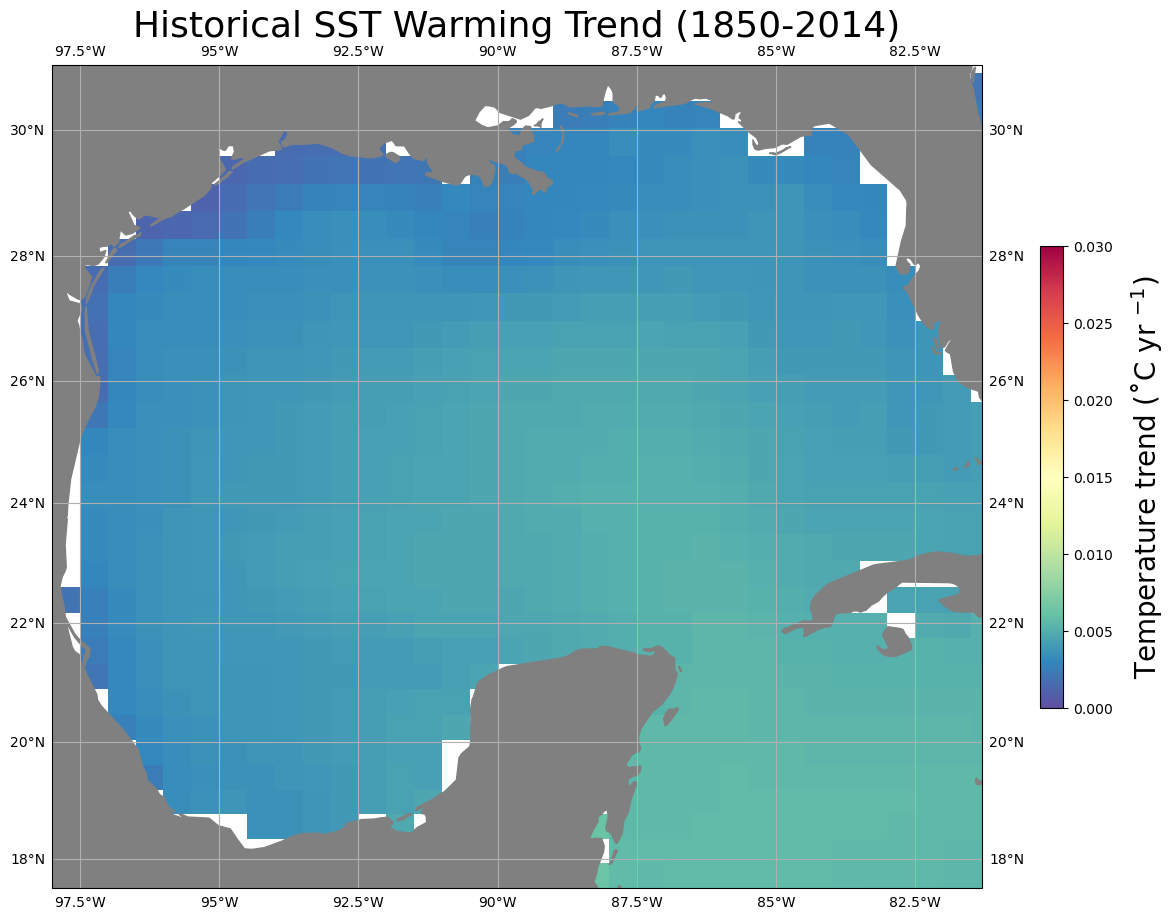

In [150]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend_hist.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=0, vmax=0.03)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Historical SST Warming Trend (1850-2014)', fontsize=26);

#### 1970-2014

In [112]:
#linear regression at every grid cell over time, so that we see trend rate in ˚C/yr at each grid pt
# Calculate the linear trend at each grid point
trend_hist1970on = hist_gom_rt.sel(time=slice('1970', None)).groupby('time.year').mean('time').polyfit('year', deg=1)

In [113]:
trend_hist1970on

<xarray.Dataset> Size: 21kB
Dimensions:               (yh: 32, xh: 40, degree: 2)
Coordinates:
  * yh                    (yh) float64 256B 17.31 17.73 18.14 ... 30.24 30.67
  * xh                    (xh) float64 320B -99.75 -99.25 ... -80.75 -80.25
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, yh, xh) float64 20kB nan nan ... -15.94

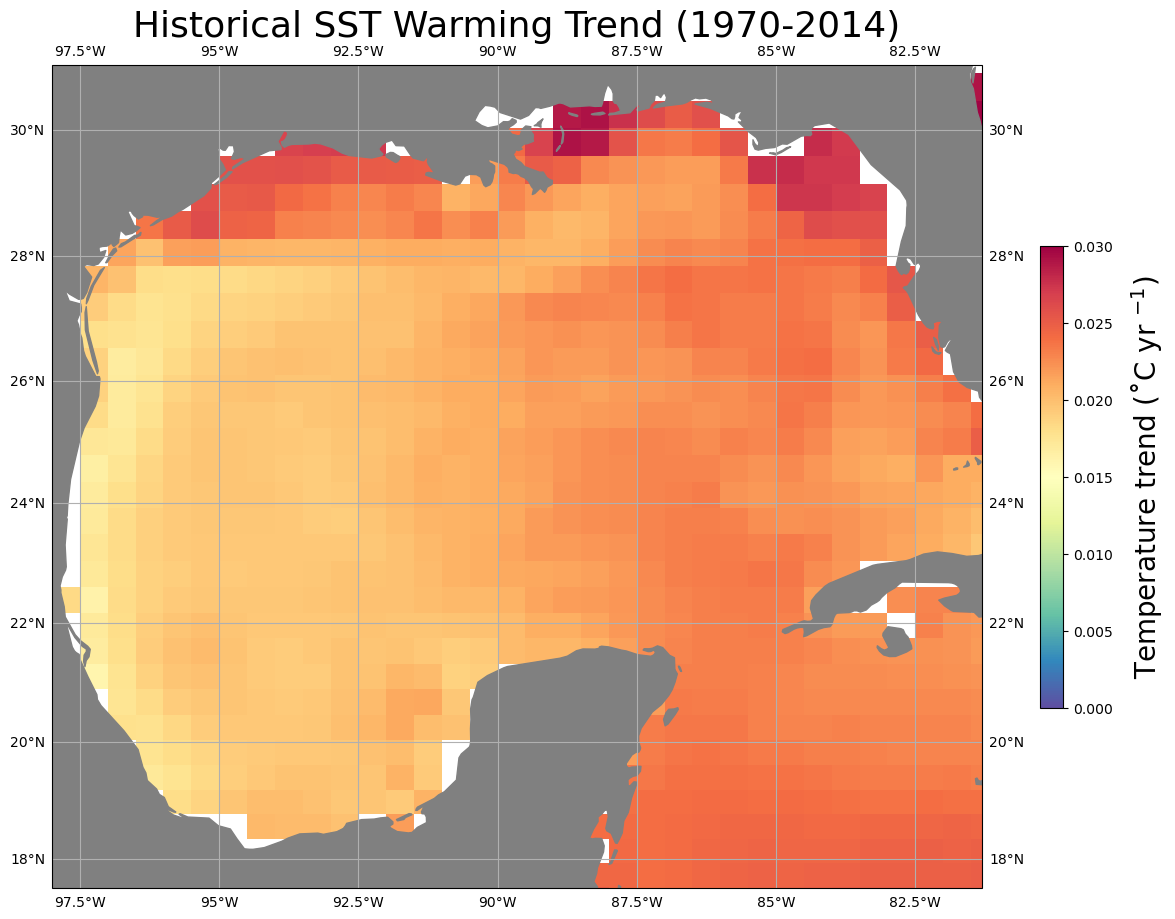

In [149]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend_hist1970on.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=0, vmax=0.03)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Historical SST Warming Trend (1970-2014)', fontsize=26);

#### 1983-2014

In [142]:
#linear regression at every grid cell over time, so that we see trend rate in ˚C/yr at each grid pt
# Calculate the linear trend at each grid point
trend_hist1983on = hist_gom_rt.sel(time=slice('1983', None)).groupby('time.year').mean('time').polyfit('year', deg=1)
trend_anom1983on = anom_gom.sel(time=slice('1983', None)).groupby('time.year').mean('time').polyfit('year', deg=1)

In [138]:
trend_hist1983on

<xarray.Dataset> Size: 21kB
Dimensions:               (yh: 32, xh: 40, degree: 2)
Coordinates:
  * yh                    (yh) float64 256B 17.31 17.73 18.14 ... 30.24 30.67
  * xh                    (xh) float64 320B -99.75 -99.25 ... -80.75 -80.25
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, yh, xh) float64 20kB nan nan ... -7.484

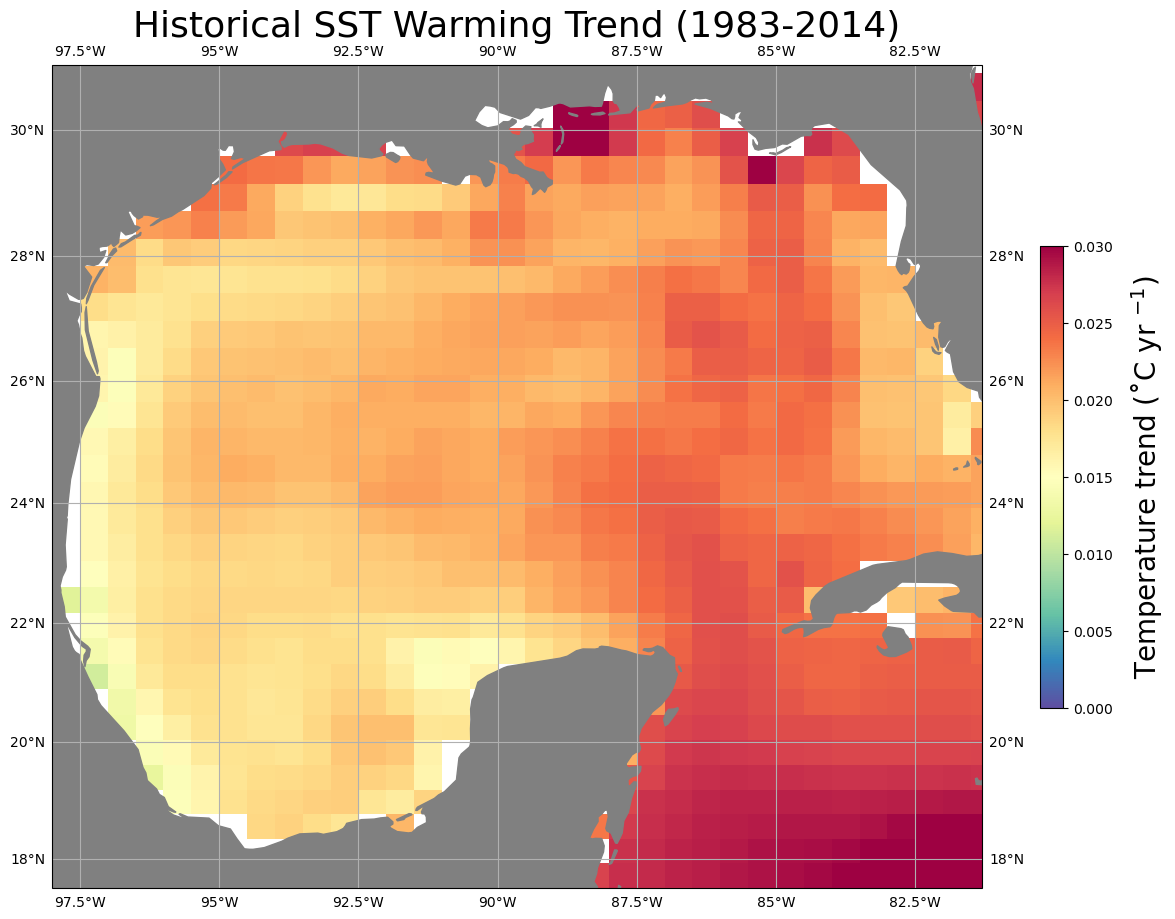

In [153]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend_hist1983on.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=0, vmax=0.03)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Historical SST Warming Trend (1983-2014)', fontsize=26);

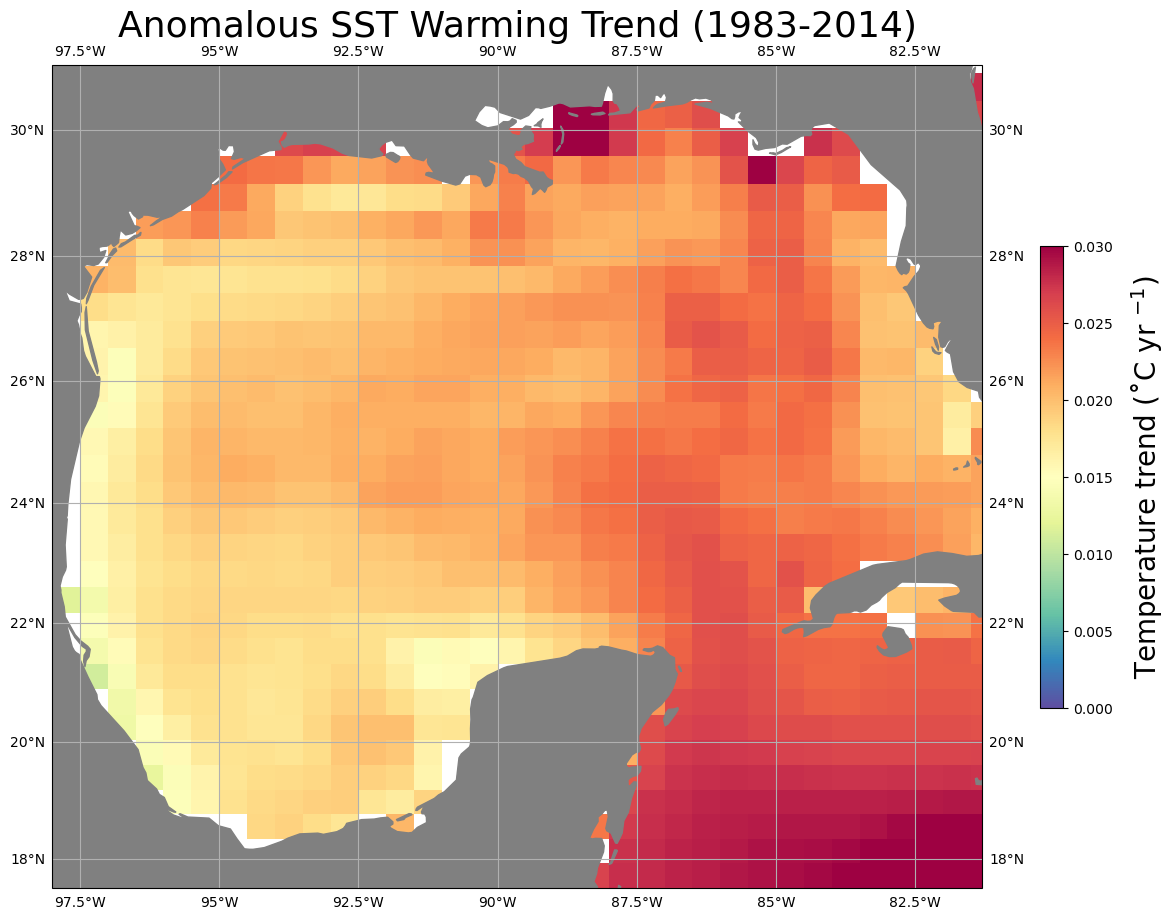

In [154]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend_anom1983on.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=0, vmax=0.03)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Anomalous SST Warming Trend (1983-2014)', fontsize=26);

In [119]:
hist_yrly_clim = hist_gom_rt.groupby('time.year').mean()

In [121]:
hist_yrly_clim

<xarray.DataArray 'tos' (year: 165, yh: 32, xh: 40)> Size: 845kB
array([[[      nan,       nan,       nan, ..., 27.52019 , 27.517317,
         27.524734],
        [      nan,       nan,       nan, ..., 27.560108, 27.580956,
         27.603773],
        [      nan,       nan,       nan, ..., 27.638079, 27.662642,
         27.688677],
        ...,
        [      nan,       nan,       nan, ..., 21.750744, 23.245642,
         24.48069 ],
        [      nan,       nan,       nan, ..., 21.384594, 22.947226,
         24.36494 ],
        [      nan,       nan,       nan, ..., 20.570124, 21.655933,
         23.881472]],

       [[      nan,       nan,       nan, ..., 27.180876, 27.16708 ,
         27.167831],
        [      nan,       nan,       nan, ..., 27.212166, 27.211212,
         27.22776 ],
        [      nan,       nan,       nan, ..., 27.26271 , 27.283295,
         27.324024],
...
        [      nan,       nan,       nan, ..., 23.251968, 24.346348,
         25.566944],
        [      nan,       nan,       nan, ..., 23.034996, 23.954865,
         25.437265],
        [      nan,       nan,       nan, ..., 22.26925 , 22.634598,
         24.818525]],

       [[      nan,       nan,       nan, ..., 28.396168, 28.381538,
         28.384073],
        [      nan,       nan,       nan, ..., 28.45577 , 28.457489,
         28.470404],
        [      nan,       nan,       nan, ..., 28.538784, 28.546295,
         28.560944],
        ...,
        [      nan,       nan,       nan, ..., 23.467825, 24.67073 ,
         25.770044],
        [      nan,       nan,       nan, ..., 23.151262, 24.311502,
         25.645151],
        [      nan,       nan,       nan, ..., 22.502153, 23.172577,
         25.078588]]], dtype=float32)
Coordinates:
  * xh       (xh) float64 320B -99.75 -99.25 -98.75 ... -81.25 -80.75 -80.25
  * yh       (yh) float64 256B 17.31 17.73 18.14 18.56 ... 29.81 30.24 30.67
  * year     (year) int64 1kB 1850 1851 1852 1853 1854 ... 2011 2012 2013 2014
Attributes:
    long_name:      Sea Surface Temperature
    units:          degC
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

In [122]:
#go off of spatial avg instead of sum so that we see trend line in regular ˚C, otherwise we're just adding ˚C
trend_hy = linregress(np.arange(0,165), hist_yrly_clim.mean(['xh', 'yh']))

In [123]:
trend_hy

LinregressResult(slope=0.004212110338676524, intercept=25.793358935871105, rvalue=0.6464740173206995, pvalue=6.708083713247096e-21, stderr=0.0003893525041519201, intercept_stderr=0.03692217020986284)

In [124]:
trend_line = (trend_hy[0]*np.arange(0,165) + trend_hy[1])

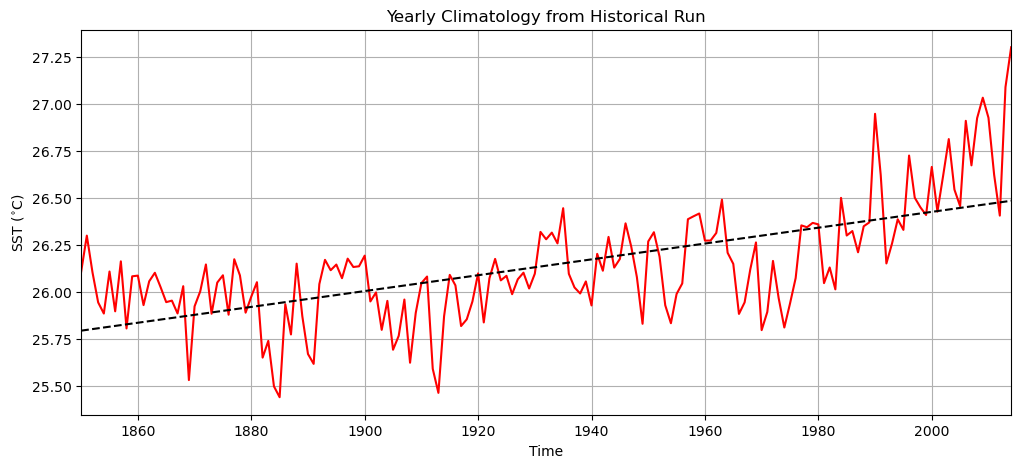

In [127]:
plt.figure(figsize=(12,5))
hist_yrly_clim.mean(('yh','xh')).plot(color='r')
plt.plot(hist_yrly_clim.year, trend_line, color='k', linestyle='dashed')
plt.grid()
plt.ylabel(r'SST ($^{\circ}$C)')
plt.xlabel('Time')
plt.xlim(hist_yrly_clim.year[0], hist_yrly_clim.year[-1])
plt.title('Yearly Climatology from Historical Run');

In [133]:
#linear regression at every grid cell over time, so that we see trend rate in ˚C/yr at each grid pt
# Calculate the linear trend at each grid point
trend_hist_yrly = hist_yrly_clim.sel(year=slice('1970', None)).polyfit('year', deg=1)

In [134]:
trend_hist_yrly

<xarray.Dataset> Size: 21kB
Dimensions:               (yh: 32, xh: 40, degree: 2)
Coordinates:
  * yh                    (yh) float64 256B 17.31 17.73 18.14 ... 30.24 30.67
  * xh                    (xh) float64 320B -99.75 -99.25 ... -80.75 -80.25
  * degree                (degree) int64 16B 1 0
Data variables:
    polyfit_coefficients  (degree, yh, xh) float64 20kB nan nan ... -15.94

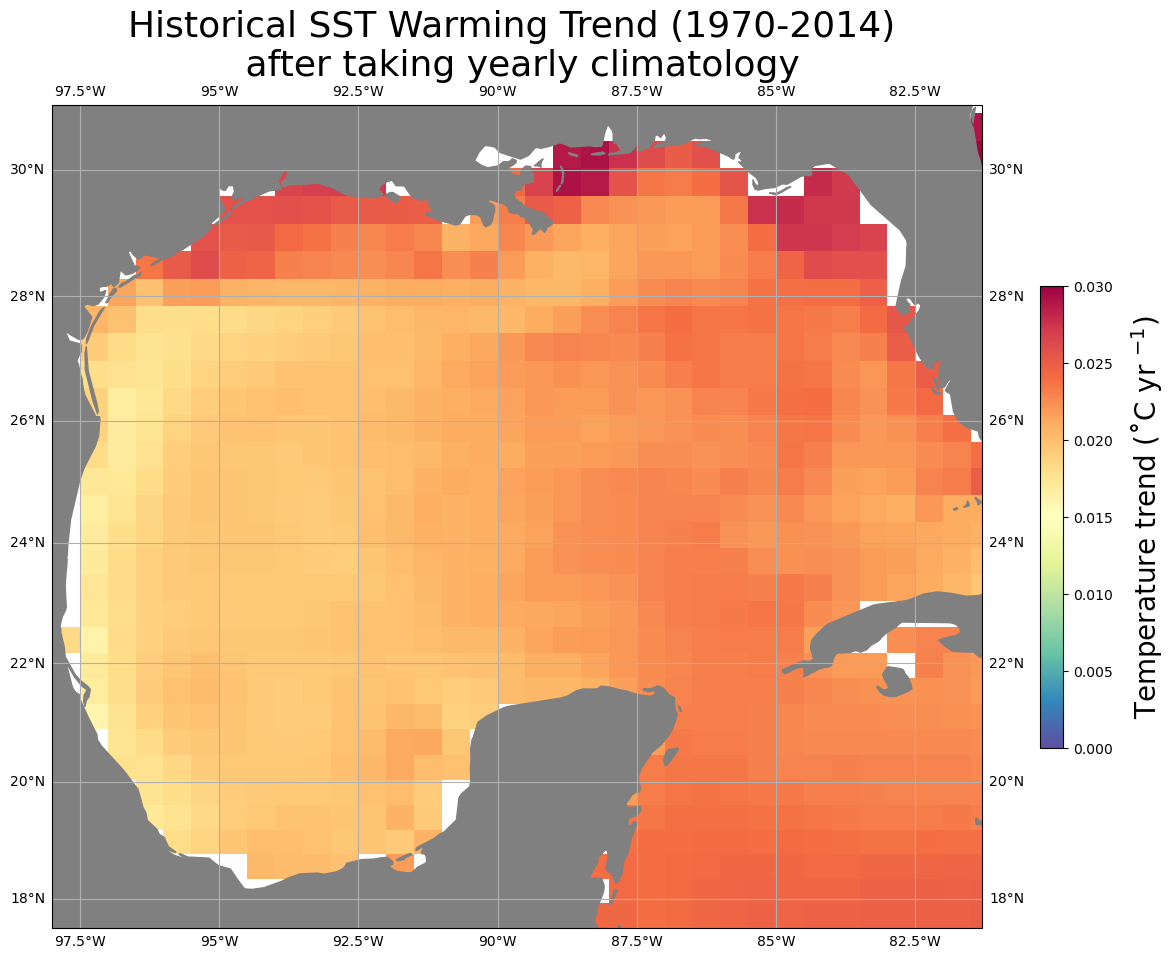

In [136]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-98, -81.3, 17.5, 31], crs=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
da = trend_hist_yrly.polyfit_coefficients[0]
im = ax.pcolormesh(da.xh, da.yh, da, transform=ccrs.PlateCarree(), 
                   cmap='Spectral_r', vmin=0, vmax=0.03)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label(r"Temperature trend (˚C yr $^{-1}$)", labelpad=12, fontsize=20)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

plt.title('Historical SST Warming Trend (1970-2014) \n after taking yearly climatology', fontsize=26);